In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from loguru import logger
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

%matplotlib inline

In [5]:
logger.info('Loading Data Set')
df = pd.read_csv('../data/timeseries.csv', sep=',', parse_dates=[0],
                 date_format='%Y%m%d', low_memory=True)

df_future = pd.read_csv('../data/future.csv', sep=',', parse_dates=[0],
                 date_format='%Y%m%d', low_memory=True)

2023-10-14 08:36:11.260 | INFO     | __main__:<module>:1 - Loading Data Set


In [6]:
df.tail()

,DateKey,PersianStr,persian_holiday,SR_TotalGrossWeight,SR_TotalNetWeight,SR_TotalSalePrice
2022,2023-10-03,1402/07/11,1,NaN,NaN,NaN
2023,2023-10-04,1402/07/12,0,279816224.0,248326476.0,3.654001e+11
2024,2023-10-05,1402/07/13,0,239947336.0,214167012.0,3.242768e+11
2025,2023-10-06,1402/07/14,1,NaN,NaN,NaN
2026,2023-10-07,1402/07/15,0,286270861.0,260587322.0,3.378790e+11


In [7]:
df_future

,DateKey,PersianStr,persian_holiday,SR_TotalGrossWeight,SR_TotalNetWeight,SR_TotalSalePrice
0,2023-10-07,1402/07/15,0,286270861.0,260587322.0,3.378790e+11
1,2023-10-08,1402/07/16,0,231779932.0,207541502.0,3.122793e+11
2,2023-10-09,1402/07/17,0,232621189.0,204296987.0,3.128464e+11
3,2023-10-10,1402/07/18,0,210994375.0,189357045.0,2.737864e+11
4,2023-10-11,1402/07/19,0,165964284.0,150034232.0,2.168524e+11
5,2023-10-12,1402/07/20,0,217391860.0,193849965.0,2.822693e+11
6,2023-10-13,1402/07/21,1,NaN,NaN,NaN


In [8]:
df['Office_holiday'] = 0
office_holiday = list(df.query('persian_holiday == True and SR_TotalNetWeight == 0').index)
holiday_list = list(df.query('SR_TotalSalePrice == 0 and persian_holiday == False').index)

for indx in holiday_list:
    df.loc[indx, 'persian_holiday'] = 1


for indx in df.index:
    if (df.loc[indx, 'persian_holiday'] == True) and (indx in office_holiday):
        df.loc[indx, 'Office_holiday'] = 1
    continue

for indx in list(df.query('SR_TotalSalePrice < 0').index):
    df.loc[indx, 'SR_TotalSalePrice'] = 0

df.dropna(inplace=True)
df.drop(columns='PersianStr', inplace=True)
df.set_index('DateKey', inplace=True)

In [9]:
df_sale = df[['SR_TotalSalePrice']].copy()
df_sale

,SR_TotalSalePrice
DateKey,
2018-03-26,9.331029e+08
2018-03-27,1.284765e+09
2018-03-28,2.225602e+09
2018-03-29,1.590548e+09
2018-04-03,1.787774e+09
...,...
2023-10-01,3.196061e+11
2023-10-02,3.702966e+11
2023-10-04,3.654001e+11


In [10]:
# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_sale)

In [11]:
# Number of past time steps to consider for prediction
sequence_length = 7

# Prepare the data for LSTM training
X = []
y = []
for i in range(sequence_length, len(df_sale)):
    X.append(scaled_data[i - sequence_length:i])
    y.append(scaled_data[i, 0])  # Predicting the 'price' column

X = np.array(X)
y = np.array(y)

# Split the data into training and testing sets
train_size = int(0.8 * len(df_sale))
X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], \
    y[:train_size], y[train_size:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1284, 7, 1), (314, 7, 1), (1284,), (314,))

In [12]:
# Build the LSTM model
logger.info('Buliding LSTM Model')
regressor = Sequential()

# Define the learning rate schedule
lr_schedule = ExponentialDecay(initial_learning_rate=1e-3,
                               decay_steps=10000, decay_rate=1e-5)

opt = Adam(learning_rate=lr_schedule)

# Add the LSTM layers and dropout
regressor.add(LSTM(units=50, activation='relu',
                   input_shape=(X_train.shape[1], X_train.shape[2]),
                   return_sequences=True))

regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50, activation='relu', return_sequences=False))
regressor.add(Dropout(0.2))

# Add the output layer
regressor.add(Dense(units=1, activation='linear'))

# Compile the model
logger.info('Compile Model')
regressor.compile(optimizer=opt, loss='mean_squared_error')

# Train the model
logger.info('Training Model...')
regressor.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)
logger.info('Training Model is Done!')

2023-10-14 08:36:47.105 | INFO     | __main__:<module>:2 - Buliding LSTM Model
2023-10-14 08:36:47.111024: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2023-10-14 08:36:47.247 | INFO     | __main__:<module>:25 - Compile Model
2023-10-14 08:36:47.250 | INFO     | __main__:<module>:29 - Training Model...
2023-10-14 08:37:12.484 | INFO     | __main__:<module>:31 - Training Model is Done!


In [13]:
# Evaluate the model on the test data
logger.info('Evaluate Model')
test_loss = regressor.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

2023-10-14 08:37:19.194 | INFO     | __main__:<module>:2 - Evaluate Model


10/10 [==============================] - 0s 5ms/step - loss: 0.0148
Test Loss: 0.014761902391910553


In [14]:
prediction = regressor.predict(X_test).flatten()
df_predicted = pd.DataFrame(data={'prediction': prediction, 'Actuals': y_test})

10/10 [==============================] - 0s 4ms/step


In [15]:
# Define the number of steps you want to forecast
forecast_steps = 12

# Initialize an array to store the forecasted values
forecasted_values = []

# Use the last 'sequence_length' data points
current_data = scaled_data[-sequence_length:].reshape(1, sequence_length, df_sale.shape[1])

logger.info('Start Forecasting Futures ...')

# Make forecasts for each future time step
for _ in range(forecast_steps):
    # Predict the next value
    next_value = regressor.predict(current_data)

    # Append the predicted value to the forecasted_values array
    forecasted_values.append(next_value)

    # Update current_data with the predicted value for the next iteration
    current_data = np.append(current_data[:, 1:, :], next_value[:, np.newaxis], axis=1)  # FIXME:

logger.info('Forecasting is Done!')

2023-10-14 08:37:31.889 | INFO     | __main__:<module>:10 - Start Forecasting Futures ...


1/1 [==============================] - 0s 12ms/step


2023-10-14 08:37:32.284 | INFO     | __main__:<module>:23 - Forecasting is Done!


In [16]:
forecasted_values

[array([[0.5609843]], dtype=float32),
 array([[0.5532072]], dtype=float32),
 array([[0.5467217]], dtype=float32),
 array([[0.5383841]], dtype=float32),
 array([[0.524879]], dtype=float32),
 array([[0.5108884]], dtype=float32),
 array([[0.50073874]], dtype=float32),
 array([[0.4882902]], dtype=float32),
 array([[0.47851834]], dtype=float32),
 array([[0.4687427]], dtype=float32),
 array([[0.45901817]], dtype=float32),
 array([[0.44941]], dtype=float32)]

In [17]:
forecasted_values = np.array(forecasted_values).reshape(forecast_steps, -1)

In [18]:
forecasted_values.shape

(12, 1)

In [29]:
forecasted_values = scaler.inverse_transform(forecasted_values)

In [30]:
# Create a DataFrame to store the forecasted values with appropriate timestamps
future_dates = pd.date_range(start=df_sale.index[-1] + pd.DateOffset(days=1),
                             periods=forecast_steps)

future_dates

DatetimeIndex(['2023-10-08', '2023-10-09', '2023-10-10', '2023-10-11',
               '2023-10-12', '2023-10-13', '2023-10-14', '2023-10-15',
               '2023-10-16', '2023-10-17', '2023-10-18', '2023-10-19'],
              dtype='datetime64[ns]', freq='D')

In [31]:
forecast_df = pd.DataFrame(data=forecasted_values, columns=df_sale.columns,
                           index=future_dates)

In [32]:
forecast_df

,SR_TotalSalePrice
2023-10-08,3.118197e+11
2023-10-09,3.074968e+11
2023-10-10,3.038919e+11
2023-10-11,2.992575e+11
2023-10-12,2.917508e+11
2023-10-13,2.839742e+11
2023-10-14,2.783326e+11
2023-10-15,2.714131e+11
2023-10-16,2.659815e+11
2023-10-17,2.605478e+11


In [59]:
df_future

,SR_TotalSalePrice
DateKey,
2023-10-07,3.378790e+11
2023-10-08,3.122793e+11
2023-10-09,3.128464e+11
2023-10-10,2.737864e+11
2023-10-11,2.168524e+11
2023-10-12,2.822693e+11
2023-10-13,NaN


In [64]:
2.822693e+11 - 2.917508e+11

-9481500000.0

In [62]:
3.122793e+11

312279300000.0

In [57]:
df_future.drop(columns=['PersianStr', 'persian_holiday', 'SR_TotalGrossWeight', 'SR_TotalNetWeight'], inplace=True)
df_future.set_index('DateKey', inplace=True)

In [58]:
df_future.SR_TotalSalePrice - forecast_df.SR_TotalSalePrice

2023-10-07             NaN
2023-10-08    4.596232e+08
2023-10-09    5.349547e+09
2023-10-10   -3.010555e+10
2023-10-11   -8.240509e+10
2023-10-12   -9.481477e+09
2023-10-13             NaN
2023-10-14             NaN
2023-10-15             NaN
2023-10-16             NaN
2023-10-17             NaN
2023-10-18             NaN
2023-10-19             NaN
Name: SR_TotalSalePrice, dtype: float64

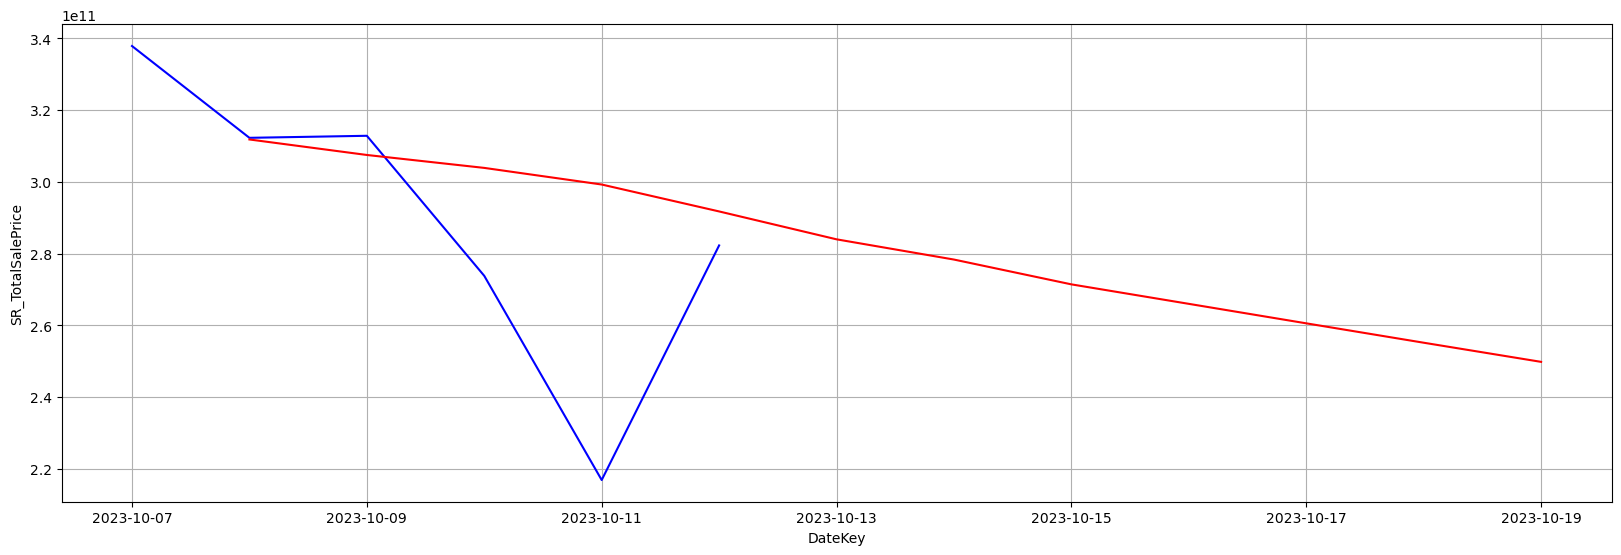

In [54]:
plt.figure(figsize=(20, 6.2));

sns.lineplot(data=df_future,
             x=df_future.DateKey, y=df_future['SR_TotalSalePrice'],
             color='b')
sns.lineplot(
             x=forecast_df.index, y=forecast_df['SR_TotalSalePrice'],
             color='r')

plt.grid()